In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [ ]:
#  Load Dataset
df = pd.read_csv("/content/GOOG.csv")
df.head(5)

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOG,2016-06-14 00:00:00+00:00,718.27,722.47,713.1200,716.48,1306065,718.27,722.47,713.1200,716.48,1306065,0.0,1.0
1,GOOG,2016-06-15 00:00:00+00:00,718.92,722.98,717.3100,719.00,1214517,718.92,722.98,717.3100,719.00,1214517,0.0,1.0
2,GOOG,2016-06-16 00:00:00+00:00,710.36,716.65,703.2600,714.91,1982471,710.36,716.65,703.2600,714.91,1982471,0.0,1.0
3,GOOG,2016-06-17 00:00:00+00:00,691.72,708.82,688.4515,708.65,3402357,691.72,708.82,688.4515,708.65,3402357,0.0,1.0
4,GOOG,2016-06-20 00:00:00+00:00,693.71,702.48,693.4100,698.77,2082538,693.71,702.48,693.4100,698.77,2082538,0.0,1.0


In [ ]:
df1 = df.reset_index()['close']

In [ ]:
df1.shape

(1258,)

In [ ]:
print(df1)

0        718.27
1        718.92
2        710.36
3        691.72
4        693.71
         ...   
1253    2466.09
1254    2482.85
1255    2491.40
1256    2521.60
1257    2513.93
Name: close, Length: 1258, dtype: float64


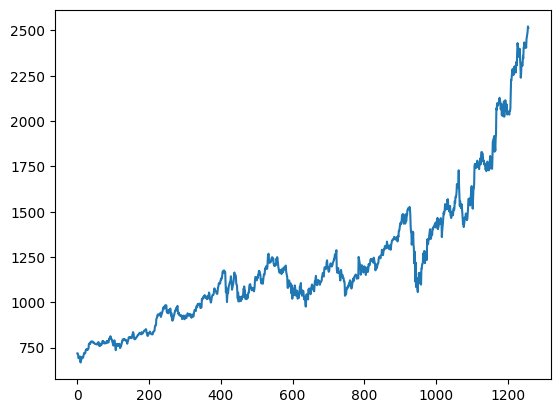

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [ ]:
# LSTM are sensitive to the scale of data hence we apply minmaxsaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform( np.array(df1).reshape(-1,1) )

In [ ]:
print(df1)

[[0.02698372]
 [0.02733443]
 [0.02271575]
 ...
 [0.98370509]
 [1.        ]
 [0.99586153]]


In [ ]:
# Train test Split

# spliting train test data as this is time series data we need to be carefull. for stock
# price previous 'n' days price affect the next day price of stock
# Divide base on date

train_size = int(len(df1)* 0.70)
test_size = len(df1) - train_size
train_data, test_data = df1[0:train_size,:], df1[train_size: len(df1), :1]


In [ ]:
train_size, test_size

(880, 378)

In [ ]:
# convert an array of values into a dataset matrix

def create_dataset( dataset, time_step=1 ) :
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        dataX.append(dataset[i:(i+time_step), 0])
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)


In [ ]:
# reshape into X=t, t+1, t+2, t+3, t+4 and Y = t+4

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(779, 100)
(779,)


In [ ]:
print(X_test.shape)
print(y_test.shape)

(277, 100)
(277,)


In [ ]:
# reshape input to [sample, time steps, feature] which is required for LSTM

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1 )
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1 )


In [ ]:
#  Create the Stacked LSTM model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

model = Sequential()
model.add( LSTM(50, return_sequences=True, input_shape=(100,1)) )
model.add( LSTM(50, return_sequences=True ) )
model.add( LSTM(50) )
model.add( Dense(1) )

model.compile( loss='mean_squared_error', optimizer='adam' )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit( X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size = 64, verbose=1)

Epoch 1/100
13/13 [==============================] - 11s 342ms/step - loss: 0.0132 - val_loss: 0.0746
Epoch 2/100
13/13 [==============================] - 2s 160ms/step - loss: 0.0022 - val_loss: 0.0227
Epoch 3/100
13/13 [==============================] - 2s 162ms/step - loss: 0.0012 - val_loss: 0.0207
Epoch 4/100
13/13 [==============================] - 2s 167ms/step - loss: 5.5473e-04 - val_loss: 0.0086
Epoch 5/100
13/13 [==============================] - 2s 194ms/step - loss: 4.4447e-04 - val_loss: 0.0043
Epoch 6/100
13/13 [==============================] - 3s 201ms/step - loss: 4.1496e-04 - val_loss: 0.0050
Epoch 7/100
13/13 [==============================] - 2s 160ms/step - loss: 3.9540e-04 - val_loss: 0.0052
Epoch 8/100
13/13 [==============================] - 2s 163ms/step - loss: 4.0693e-04 - val_loss: 0.0053
Epoch 9/100
13/13 [==============================] - 2s 165ms/step - loss: 3.9857e-04 - val_loss: 0.0055
Epoch 10/100
13/13 [==============================] - 2s 163ms/ste

In [ ]:
# Lets Do prediction and check performance metrics

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transform to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


9/9 [==============================] - 0s 32ms/step


In [ ]:
#  Calculate RMSE performance metrics
import math

from sklearn.metrics import mean_squared_error
print (math.sqrt(mean_squared_error(y_train, train_predict)))
print (math.sqrt(mean_squared_error(y_test, test_predict)))

1061.6150918003214
1740.5795814589221


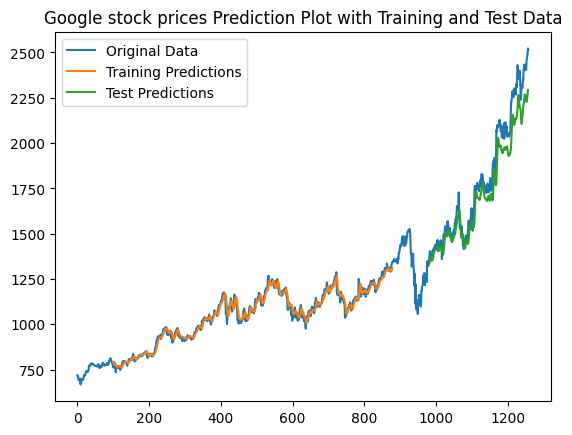

In [ ]:
# Plotting

look_back = 100

trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back: len(train_predict) + look_back, :] = train_predict

testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[ len(train_predict) + (look_back*2)+1 : len(df1)-1, : ] = test_predict

plt.title('Google stock prices Prediction Plot with Training and Test Data')
plt.plot(scaler.inverse_transform(df1), label='Original Data')
plt.plot(trainPredictPlot, label='Training Predictions')
plt.plot(testPredictPlot, label='Test Predictions')
plt.legend()
plt.show()
